In [4]:
import os
import cv2
from tqdm import tqdm
import albumentations as A
from PIL import Image
import numpy as np
from pathlib import Path

input_dir = Path("/kaggle/input/fishhhhh/Fishes")
output_dir = Path("/kaggle/working/augmented")
output_dir.mkdir(exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.RandomCrop(width=200, height=200, p=0.5),
    A.HueSaturationValue(p=0.3),
    A.GaussNoise(p=0.3),
])
for cls in os.listdir(input_dir):
    cls_path = input_dir / cls
    if not cls_path.is_dir():
        continue
    
    (output_dir / cls).mkdir(exist_ok=True)

    images = list(cls_path.glob("*.*"))
    
    for img_path in tqdm(images, desc=f"Augmenting {cls}"):
        img = cv2.imread(str(img_path))[:,:,::-1]
        
        # 5 augmentations per image
        for i in range(10):
            aug = transform(image=img)['image']
            aug = cv2.cvtColor(aug, cv2.COLOR_RGB2BGR)

            save_name = f"{img_path.stem}_aug_{i}.jpg"
            cv2.imwrite(str(output_dir/cls/save_name), aug)

print("DONE!")

Augmenting Croaker(Poya): 100%|██████████| 11/11 [00:24<00:00,  2.22s/it]

DONE!


In [5]:
aug_count = sum(len(files) for _,_,files in os.walk(output_dir))
print("TOTAL AUGMENTED IMAGES =", aug_count)

TOTAL AUGMENTED IMAGES = 5830


In [6]:
!pip install -q timm

In [7]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import gc, time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [8]:
# ======================================
# STEP 1: EfficientNet-B0 ENCODER
# ======================================
class EffNetB0Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(
            "efficientnet_b0",
            pretrained=pretrained,
            num_classes=0   # feature extractor only
        )
        self.out_dim = self.backbone.num_features

    def forward(self, x):
        return self.backbone(x)


In [9]:
# ======================================
# STEP 2: DINO PROJECTION HEAD + FULL NET
# ======================================
class DINOHead(nn.Module):
    """
    Simple 3-layer projection head (MLP) like DINO
    """
    def __init__(self, in_dim, hidden_dim=2048, out_dim=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        x = self.mlp(x)
        x = F.normalize(x, dim=-1)
        return x


class DINOEffNetB0(nn.Module):
    def __init__(self, pretrained_backbone=True, out_dim=256):
        super().__init__()
        self.encoder = EffNetB0Encoder(pretrained=pretrained_backbone)
        self.head = DINOHead(self.encoder.out_dim, out_dim=out_dim)

    def forward(self, x):
        feats = self.encoder(x)
        out = self.head(feats)
        return out   # [B, out_dim]


In [10]:
# ======================================
# STEP 3: DINO LOSS
# ======================================
class DINOLoss(nn.Module):
    def __init__(self, student_temp=0.1, teacher_temp=0.04, eps=1e-6):
        super().__init__()
        self.student_temp = student_temp
        self.teacher_temp = teacher_temp
        self.eps = eps

    def forward(self, student_out, teacher_out):
        """
        student_out: (N, D)
        teacher_out: (N, D)  (no grad)
        """
        # teacher: sharpened softmax
        t_logits = teacher_out / self.teacher_temp
        t_probs = F.softmax(t_logits, dim=-1)

        # student: log-softmax with student temperature
        s_logits = student_out / self.student_temp
        log_s_probs = F.log_softmax(s_logits, dim=-1)

        loss = - (t_probs * log_s_probs).sum(dim=-1).mean()
        return loss


In [11]:
# ======================================
# DEFINE CONFIG
# ======================================
class cfg:
    TRAIN_DIR = "/kaggle/working/augmented"   # <-- path ঠিক করে দাও
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 16
    NUM_WORKERS = 0
    SEED = 42

# ======================================
# STEP 4: DATASET WITH TWO GLOBAL VIEWS
# ======================================

class TwoGlobalCrops:
    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, img):
        g1 = self.base_transform(img)
        g2 = self.base_transform(img)
        return (g1, g2)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.4, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

dino_dataset = datasets.ImageFolder(
    root=cfg.TRAIN_DIR,
    transform=TwoGlobalCrops(train_transform)
)

dino_loader = DataLoader(
    dino_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

print("DINO dataset size:", len(dino_dataset))


DINO dataset size: 5830


In [15]:
# ======================================
# CLEAN DINO TRAINING LOOP (PROPER PROGRESS BAR)
# ======================================
def train_dino(
    student,
    teacher,
    loader,
    loss_fn,
    epochs=80,
    lr=1e-4,
    ema_m=0.996,
    max_steps_per_epoch=40  # fast rakhte; None dile full loader cholbe
):
    student.to(cfg.DEVICE)
    teacher.to(cfg.DEVICE)

    # teacher frozen
    for p in teacher.parameters():
        p.requires_grad = False

    optimizer = torch.optim.Adam(student.parameters(), lr=lr)
    loss_history = []

    # total steps per epoch (progress bar er jonno)
    if max_steps_per_epoch is None:
        steps_per_epoch = len(loader)
    else:
        steps_per_epoch = min(max_steps_per_epoch, len(loader))

    for epoch in range(1, epochs + 1):
        student.train()
        teacher.eval()

        epoch_loss = 0.0
        n_batches = 0
        t0 = time.time()

        # tqdm with fixed total = steps_per_epoch
        pbar = tqdm(total=steps_per_epoch, desc=f"Epoch {epoch}/{epochs}", leave=False)

        for step, ((g1, g2), _) in enumerate(loader):
            if step >= steps_per_epoch:
                break

            g1 = g1.to(cfg.DEVICE, non_blocking=True)
            g2 = g2.to(cfg.DEVICE, non_blocking=True)

            # ----- STUDENT -----
            s1 = student(g1)
            s2 = student(g2)
            student_out = torch.cat([s1, s2], dim=0)

            # ----- TEACHER -----
            with torch.no_grad():
                t1 = teacher(g1)
                t2 = teacher(g2)
                teacher_out = torch.cat([t1, t2], dim=0)

            # ----- LOSS -----
            loss = loss_fn(student_out, teacher_out)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # ----- EMA UPDATE -----
            with torch.no_grad():
                for ps, pt in zip(student.parameters(), teacher.parameters()):
                    pt.data = pt.data * ema_m + ps.data * (1.0 - ema_m)

            epoch_loss += loss.item()
            n_batches += 1

            pbar.set_postfix(loss=f"{loss.item():.4f}")
            pbar.update(1)

        pbar.close()

        avg_loss = epoch_loss / max(1, n_batches)
        loss_history.append(avg_loss)
        print(
            f"Epoch {epoch}/{epochs} | "
            f"Avg Loss: {avg_loss:.4f} | "
            f"Time: {time.time()-t0:.1f}s | "
            f"Batches: {n_batches}"
        )

    return student, teacher, loss_history


In [16]:
# ======================================
# STEP 6: DINO + EfficientNet-B0 (3 TEMPS, 80 EPOCH, FAST)
# ======================================
TEMPERATURES = [0.1, 0.2, 0.5]
NUM_EPOCHS = 80
MAX_STEPS_PER_EPOCH = 40   # fast rakhte; slow hole 20–30 kore dio

dino_students = {}
dino_teachers = {}
dino_loss_histories = {}

for temp in TEMPERATURES:
    print("\n" + "="*60)
    print(f" TRAINING DINO + EfficientNet-B0 FOR TEMPERATURE = {temp}")
    print("="*60)

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    student = DINOEffNetB0(pretrained_backbone=True, out_dim=256)
    teacher = DINOEffNetB0(pretrained_backbone=True, out_dim=256)
    teacher.load_state_dict(student.state_dict())

    dino_loss = DINOLoss(student_temp=temp, teacher_temp=0.04).to(cfg.DEVICE)

    student, teacher, losses = train_dino(
        student=student,
        teacher=teacher,
        loader=dino_loader,
        loss_fn=dino_loss,
        epochs=NUM_EPOCHS,
        lr=1e-4,
        ema_m=0.996,
        max_steps_per_epoch=MAX_STEPS_PER_EPOCH
    )

    dino_students[temp] = student
    dino_teachers[temp] = teacher
    dino_loss_histories[temp] = losses

    print(f"\n COMPLETED DINO TRAINING FOR TEMP = {temp}\n")



 TRAINING DINO + EfficientNet-B0 FOR TEMPERATURE = 0.1


Epoch 1/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/80 | Avg Loss: 4.8390 | Time: 60.7s | Batches: 40


Epoch 2/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/80 | Avg Loss: 4.1630 | Time: 59.3s | Batches: 40


Epoch 3/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/80 | Avg Loss: 3.1238 | Time: 61.8s | Batches: 40


Epoch 4/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/80 | Avg Loss: 2.0515 | Time: 63.1s | Batches: 40


Epoch 5/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/80 | Avg Loss: 1.3068 | Time: 62.7s | Batches: 40


Epoch 6/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/80 | Avg Loss: 0.9839 | Time: 62.0s | Batches: 40


Epoch 7/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/80 | Avg Loss: 0.7600 | Time: 61.9s | Batches: 40


Epoch 8/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/80 | Avg Loss: 0.6044 | Time: 58.1s | Batches: 40


Epoch 9/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/80 | Avg Loss: 0.5081 | Time: 61.4s | Batches: 40


Epoch 10/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/80 | Avg Loss: 0.4059 | Time: 59.5s | Batches: 40


Epoch 11/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/80 | Avg Loss: 0.3519 | Time: 59.9s | Batches: 40


Epoch 12/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/80 | Avg Loss: 0.3571 | Time: 62.2s | Batches: 40


Epoch 13/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/80 | Avg Loss: 0.3093 | Time: 58.6s | Batches: 40


Epoch 14/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/80 | Avg Loss: 0.3298 | Time: 60.2s | Batches: 40


Epoch 15/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/80 | Avg Loss: 0.2781 | Time: 60.5s | Batches: 40


Epoch 16/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/80 | Avg Loss: 0.2763 | Time: 59.2s | Batches: 40


Epoch 17/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/80 | Avg Loss: 0.2661 | Time: 61.6s | Batches: 40


Epoch 18/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/80 | Avg Loss: 0.2526 | Time: 58.2s | Batches: 40


Epoch 19/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/80 | Avg Loss: 0.2799 | Time: 61.8s | Batches: 40


Epoch 20/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/80 | Avg Loss: 0.2650 | Time: 59.5s | Batches: 40


Epoch 21/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/80 | Avg Loss: 0.2238 | Time: 61.2s | Batches: 40


Epoch 22/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/80 | Avg Loss: 0.2240 | Time: 59.6s | Batches: 40


Epoch 23/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/80 | Avg Loss: 0.2181 | Time: 61.5s | Batches: 40


Epoch 24/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/80 | Avg Loss: 0.1959 | Time: 61.1s | Batches: 40


Epoch 25/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/80 | Avg Loss: 0.1761 | Time: 60.1s | Batches: 40


Epoch 26/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/80 | Avg Loss: 0.1458 | Time: 62.2s | Batches: 40


Epoch 27/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/80 | Avg Loss: 0.1834 | Time: 62.3s | Batches: 40


Epoch 28/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/80 | Avg Loss: 0.1631 | Time: 57.9s | Batches: 40


Epoch 29/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/80 | Avg Loss: 0.1387 | Time: 58.4s | Batches: 40


Epoch 30/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/80 | Avg Loss: 0.1066 | Time: 58.0s | Batches: 40


Epoch 31/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31/80 | Avg Loss: 0.0850 | Time: 62.3s | Batches: 40


Epoch 32/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32/80 | Avg Loss: 0.1392 | Time: 61.7s | Batches: 40


Epoch 33/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33/80 | Avg Loss: 0.1488 | Time: 57.8s | Batches: 40


Epoch 34/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34/80 | Avg Loss: 0.1334 | Time: 59.8s | Batches: 40


Epoch 35/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35/80 | Avg Loss: 0.1313 | Time: 61.5s | Batches: 40


Epoch 36/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36/80 | Avg Loss: 0.1522 | Time: 60.4s | Batches: 40


Epoch 37/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37/80 | Avg Loss: 0.1469 | Time: 57.7s | Batches: 40


Epoch 38/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38/80 | Avg Loss: 0.1202 | Time: 61.5s | Batches: 40


Epoch 39/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39/80 | Avg Loss: 0.1380 | Time: 61.2s | Batches: 40


Epoch 40/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40/80 | Avg Loss: 0.0979 | Time: 60.5s | Batches: 40


Epoch 41/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41/80 | Avg Loss: 0.0927 | Time: 63.2s | Batches: 40


Epoch 42/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42/80 | Avg Loss: 0.0911 | Time: 60.8s | Batches: 40


Epoch 43/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43/80 | Avg Loss: 0.0726 | Time: 63.2s | Batches: 40


Epoch 44/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44/80 | Avg Loss: 0.0495 | Time: 56.7s | Batches: 40


Epoch 45/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45/80 | Avg Loss: 0.0343 | Time: 59.7s | Batches: 40


Epoch 46/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46/80 | Avg Loss: 0.0174 | Time: 59.7s | Batches: 40


Epoch 47/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47/80 | Avg Loss: 0.0142 | Time: 60.8s | Batches: 40


Epoch 48/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48/80 | Avg Loss: 0.0131 | Time: 63.2s | Batches: 40


Epoch 49/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49/80 | Avg Loss: 0.0128 | Time: 56.2s | Batches: 40


Epoch 50/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50/80 | Avg Loss: 0.0123 | Time: 56.2s | Batches: 40


Epoch 51/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 51/80 | Avg Loss: 0.0122 | Time: 60.9s | Batches: 40


Epoch 52/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 52/80 | Avg Loss: 0.0121 | Time: 59.4s | Batches: 40


Epoch 53/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 53/80 | Avg Loss: 0.0119 | Time: 62.5s | Batches: 40


Epoch 54/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 54/80 | Avg Loss: 0.0120 | Time: 61.3s | Batches: 40


Epoch 55/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 55/80 | Avg Loss: 0.0119 | Time: 58.7s | Batches: 40


Epoch 56/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 56/80 | Avg Loss: 0.0119 | Time: 61.7s | Batches: 40


Epoch 57/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 57/80 | Avg Loss: 0.0118 | Time: 61.8s | Batches: 40


Epoch 58/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 58/80 | Avg Loss: 0.0117 | Time: 62.1s | Batches: 40


Epoch 59/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 59/80 | Avg Loss: 0.0117 | Time: 60.2s | Batches: 40


Epoch 60/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 60/80 | Avg Loss: 0.0117 | Time: 62.8s | Batches: 40


Epoch 61/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 61/80 | Avg Loss: 0.0117 | Time: 61.9s | Batches: 40


Epoch 62/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 62/80 | Avg Loss: 0.0116 | Time: 60.1s | Batches: 40


Epoch 63/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 63/80 | Avg Loss: 0.0116 | Time: 59.4s | Batches: 40


Epoch 64/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 64/80 | Avg Loss: 0.0116 | Time: 62.6s | Batches: 40


Epoch 65/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 65/80 | Avg Loss: 0.0116 | Time: 59.6s | Batches: 40


Epoch 66/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 66/80 | Avg Loss: 0.0116 | Time: 62.7s | Batches: 40


Epoch 67/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 67/80 | Avg Loss: 0.0116 | Time: 59.5s | Batches: 40


Epoch 68/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 68/80 | Avg Loss: 0.0116 | Time: 57.0s | Batches: 40


Epoch 69/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 69/80 | Avg Loss: 0.0116 | Time: 61.8s | Batches: 40


Epoch 70/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 70/80 | Avg Loss: 0.0115 | Time: 57.7s | Batches: 40


Epoch 71/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 71/80 | Avg Loss: 0.0115 | Time: 62.2s | Batches: 40


Epoch 72/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 72/80 | Avg Loss: 0.0115 | Time: 59.4s | Batches: 40


Epoch 73/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 73/80 | Avg Loss: 0.0115 | Time: 61.4s | Batches: 40


Epoch 74/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 74/80 | Avg Loss: 0.0115 | Time: 58.2s | Batches: 40


Epoch 75/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 75/80 | Avg Loss: 0.0115 | Time: 60.5s | Batches: 40


Epoch 76/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 76/80 | Avg Loss: 0.0115 | Time: 60.2s | Batches: 40


Epoch 77/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 77/80 | Avg Loss: 0.0115 | Time: 58.4s | Batches: 40


Epoch 78/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 78/80 | Avg Loss: 0.0115 | Time: 62.0s | Batches: 40


Epoch 79/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 79/80 | Avg Loss: 0.0115 | Time: 62.7s | Batches: 40


Epoch 80/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 80/80 | Avg Loss: 0.0115 | Time: 60.9s | Batches: 40

 COMPLETED DINO TRAINING FOR TEMP = 0.1


 TRAINING DINO + EfficientNet-B0 FOR TEMPERATURE = 0.2


Epoch 1/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/80 | Avg Loss: 4.5923 | Time: 60.8s | Batches: 40


Epoch 2/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/80 | Avg Loss: 2.6580 | Time: 59.9s | Batches: 40


Epoch 3/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/80 | Avg Loss: 1.6901 | Time: 61.8s | Batches: 40


Epoch 4/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/80 | Avg Loss: 1.4477 | Time: 63.1s | Batches: 40


Epoch 5/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/80 | Avg Loss: 1.3640 | Time: 58.6s | Batches: 40


Epoch 6/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/80 | Avg Loss: 1.3654 | Time: 58.9s | Batches: 40


Epoch 7/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/80 | Avg Loss: 1.3492 | Time: 57.0s | Batches: 40


Epoch 8/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/80 | Avg Loss: 1.2333 | Time: 63.7s | Batches: 40


Epoch 9/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/80 | Avg Loss: 1.2283 | Time: 59.5s | Batches: 40


Epoch 10/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/80 | Avg Loss: 1.1531 | Time: 58.8s | Batches: 40


Epoch 11/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/80 | Avg Loss: 1.1102 | Time: 61.9s | Batches: 40


Epoch 12/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/80 | Avg Loss: 1.1364 | Time: 59.4s | Batches: 40


Epoch 13/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/80 | Avg Loss: 1.1367 | Time: 59.9s | Batches: 40


Epoch 14/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/80 | Avg Loss: 1.1234 | Time: 63.2s | Batches: 40


Epoch 15/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/80 | Avg Loss: 1.1532 | Time: 59.4s | Batches: 40


Epoch 16/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/80 | Avg Loss: 1.1159 | Time: 60.5s | Batches: 40


Epoch 17/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/80 | Avg Loss: 1.0987 | Time: 60.5s | Batches: 40


Epoch 18/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/80 | Avg Loss: 1.1283 | Time: 60.1s | Batches: 40


Epoch 19/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/80 | Avg Loss: 1.1275 | Time: 61.2s | Batches: 40


Epoch 20/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/80 | Avg Loss: 1.1200 | Time: 61.4s | Batches: 40


Epoch 21/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/80 | Avg Loss: 1.1351 | Time: 60.9s | Batches: 40


Epoch 22/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/80 | Avg Loss: 1.1895 | Time: 58.3s | Batches: 40


Epoch 23/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/80 | Avg Loss: 1.1377 | Time: 62.6s | Batches: 40


Epoch 24/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/80 | Avg Loss: 1.1663 | Time: 60.6s | Batches: 40


Epoch 25/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/80 | Avg Loss: 1.1715 | Time: 59.1s | Batches: 40


Epoch 26/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/80 | Avg Loss: 1.1815 | Time: 60.5s | Batches: 40


Epoch 27/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/80 | Avg Loss: 1.1461 | Time: 62.1s | Batches: 40


Epoch 28/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/80 | Avg Loss: 1.1799 | Time: 62.9s | Batches: 40


Epoch 29/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/80 | Avg Loss: 1.1370 | Time: 59.8s | Batches: 40


Epoch 30/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/80 | Avg Loss: 1.1255 | Time: 62.6s | Batches: 40


Epoch 31/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31/80 | Avg Loss: 1.1717 | Time: 61.4s | Batches: 40


Epoch 32/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32/80 | Avg Loss: 1.1856 | Time: 63.5s | Batches: 40


Epoch 33/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33/80 | Avg Loss: 1.1739 | Time: 59.5s | Batches: 40


Epoch 34/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34/80 | Avg Loss: 1.1514 | Time: 61.4s | Batches: 40


Epoch 35/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35/80 | Avg Loss: 1.1487 | Time: 60.9s | Batches: 40


Epoch 36/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36/80 | Avg Loss: 1.1690 | Time: 60.3s | Batches: 40


Epoch 37/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37/80 | Avg Loss: 1.1896 | Time: 57.2s | Batches: 40


Epoch 38/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38/80 | Avg Loss: 1.1798 | Time: 61.1s | Batches: 40


Epoch 39/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39/80 | Avg Loss: 1.1419 | Time: 61.2s | Batches: 40


Epoch 40/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40/80 | Avg Loss: 1.2184 | Time: 57.7s | Batches: 40


Epoch 41/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41/80 | Avg Loss: 1.1399 | Time: 60.8s | Batches: 40


Epoch 42/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42/80 | Avg Loss: 1.1498 | Time: 57.8s | Batches: 40


Epoch 43/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43/80 | Avg Loss: 1.1500 | Time: 58.4s | Batches: 40


Epoch 44/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44/80 | Avg Loss: 1.1520 | Time: 59.2s | Batches: 40


Epoch 45/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45/80 | Avg Loss: 1.1648 | Time: 60.3s | Batches: 40


Epoch 46/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46/80 | Avg Loss: 1.1622 | Time: 61.0s | Batches: 40


Epoch 47/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47/80 | Avg Loss: 1.1686 | Time: 62.2s | Batches: 40


Epoch 48/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48/80 | Avg Loss: 1.1196 | Time: 61.3s | Batches: 40


Epoch 49/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49/80 | Avg Loss: 1.1045 | Time: 61.1s | Batches: 40


Epoch 50/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50/80 | Avg Loss: 1.1287 | Time: 60.5s | Batches: 40


Epoch 51/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 51/80 | Avg Loss: 1.0709 | Time: 61.1s | Batches: 40


Epoch 52/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 52/80 | Avg Loss: 1.0546 | Time: 62.1s | Batches: 40


Epoch 53/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 53/80 | Avg Loss: 1.0043 | Time: 63.1s | Batches: 40


Epoch 54/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 54/80 | Avg Loss: 1.0016 | Time: 65.2s | Batches: 40


Epoch 55/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 55/80 | Avg Loss: 0.9987 | Time: 63.2s | Batches: 40


Epoch 56/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 56/80 | Avg Loss: 0.9958 | Time: 61.0s | Batches: 40


Epoch 57/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 57/80 | Avg Loss: 0.9941 | Time: 61.7s | Batches: 40


Epoch 58/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 58/80 | Avg Loss: 0.9941 | Time: 61.8s | Batches: 40


Epoch 59/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 59/80 | Avg Loss: 0.9941 | Time: 60.5s | Batches: 40


Epoch 60/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 60/80 | Avg Loss: 1.0014 | Time: 60.9s | Batches: 40


Epoch 61/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 61/80 | Avg Loss: 0.9943 | Time: 60.9s | Batches: 40


Epoch 62/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 62/80 | Avg Loss: 0.9940 | Time: 58.9s | Batches: 40


Epoch 63/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 63/80 | Avg Loss: 0.9939 | Time: 57.9s | Batches: 40


Epoch 64/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 64/80 | Avg Loss: 0.9939 | Time: 60.9s | Batches: 40


Epoch 65/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 65/80 | Avg Loss: 0.9939 | Time: 62.6s | Batches: 40


Epoch 66/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 66/80 | Avg Loss: 0.9939 | Time: 60.2s | Batches: 40


Epoch 67/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 67/80 | Avg Loss: 0.9939 | Time: 60.5s | Batches: 40


Epoch 68/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 68/80 | Avg Loss: 0.9939 | Time: 61.1s | Batches: 40


Epoch 69/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 69/80 | Avg Loss: 0.9939 | Time: 59.2s | Batches: 40


Epoch 70/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 70/80 | Avg Loss: 0.9939 | Time: 59.5s | Batches: 40


Epoch 71/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 71/80 | Avg Loss: 0.9939 | Time: 58.2s | Batches: 40


Epoch 72/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 72/80 | Avg Loss: 0.9939 | Time: 62.0s | Batches: 40


Epoch 73/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 73/80 | Avg Loss: 0.9939 | Time: 60.6s | Batches: 40


Epoch 74/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 74/80 | Avg Loss: 0.9939 | Time: 60.2s | Batches: 40


Epoch 75/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 75/80 | Avg Loss: 0.9939 | Time: 60.3s | Batches: 40


Epoch 76/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 76/80 | Avg Loss: 0.9939 | Time: 57.9s | Batches: 40


Epoch 77/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 77/80 | Avg Loss: 0.9939 | Time: 61.6s | Batches: 40


Epoch 78/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 78/80 | Avg Loss: 0.9939 | Time: 62.0s | Batches: 40


Epoch 79/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 79/80 | Avg Loss: 0.9938 | Time: 58.7s | Batches: 40


Epoch 80/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 80/80 | Avg Loss: 0.9938 | Time: 61.7s | Batches: 40

 COMPLETED DINO TRAINING FOR TEMP = 0.2


 TRAINING DINO + EfficientNet-B0 FOR TEMPERATURE = 0.5


Epoch 1/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/80 | Avg Loss: 5.3277 | Time: 57.0s | Batches: 40


Epoch 2/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/80 | Avg Loss: 4.7540 | Time: 57.0s | Batches: 40


Epoch 3/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/80 | Avg Loss: 3.9524 | Time: 61.7s | Batches: 40


Epoch 4/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/80 | Avg Loss: 3.7157 | Time: 61.5s | Batches: 40


Epoch 5/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/80 | Avg Loss: 3.6842 | Time: 58.2s | Batches: 40


Epoch 6/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/80 | Avg Loss: 3.6623 | Time: 60.3s | Batches: 40


Epoch 7/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/80 | Avg Loss: 3.6320 | Time: 56.6s | Batches: 40


Epoch 8/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/80 | Avg Loss: 3.6137 | Time: 57.9s | Batches: 40


Epoch 9/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/80 | Avg Loss: 3.6071 | Time: 58.5s | Batches: 40


Epoch 10/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/80 | Avg Loss: 3.5966 | Time: 61.1s | Batches: 40


Epoch 11/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/80 | Avg Loss: 3.6004 | Time: 60.1s | Batches: 40


Epoch 12/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/80 | Avg Loss: 3.6033 | Time: 59.6s | Batches: 40


Epoch 13/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/80 | Avg Loss: 3.5844 | Time: 59.7s | Batches: 40


Epoch 14/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/80 | Avg Loss: 3.5865 | Time: 60.9s | Batches: 40


Epoch 15/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/80 | Avg Loss: 3.5816 | Time: 58.1s | Batches: 40


Epoch 16/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/80 | Avg Loss: 3.5812 | Time: 60.1s | Batches: 40


Epoch 17/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/80 | Avg Loss: 3.5824 | Time: 60.5s | Batches: 40


Epoch 18/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/80 | Avg Loss: 3.5858 | Time: 59.9s | Batches: 40


Epoch 19/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/80 | Avg Loss: 3.5936 | Time: 61.8s | Batches: 40


Epoch 20/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/80 | Avg Loss: 3.5863 | Time: 61.2s | Batches: 40


Epoch 21/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/80 | Avg Loss: 3.5842 | Time: 62.6s | Batches: 40


Epoch 22/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/80 | Avg Loss: 3.5789 | Time: 58.5s | Batches: 40


Epoch 23/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/80 | Avg Loss: 3.5886 | Time: 57.8s | Batches: 40


Epoch 24/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/80 | Avg Loss: 3.5844 | Time: 60.0s | Batches: 40


Epoch 25/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/80 | Avg Loss: 3.5748 | Time: 62.3s | Batches: 40


Epoch 26/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/80 | Avg Loss: 3.5749 | Time: 58.7s | Batches: 40


Epoch 27/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/80 | Avg Loss: 3.5827 | Time: 59.0s | Batches: 40


Epoch 28/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/80 | Avg Loss: 3.5768 | Time: 58.5s | Batches: 40


Epoch 29/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/80 | Avg Loss: 3.5856 | Time: 59.3s | Batches: 40


Epoch 30/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/80 | Avg Loss: 3.5879 | Time: 57.1s | Batches: 40


Epoch 31/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31/80 | Avg Loss: 3.5815 | Time: 59.2s | Batches: 40


Epoch 32/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32/80 | Avg Loss: 3.5837 | Time: 59.0s | Batches: 40


Epoch 33/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33/80 | Avg Loss: 3.5778 | Time: 58.6s | Batches: 40


Epoch 34/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34/80 | Avg Loss: 3.5821 | Time: 60.9s | Batches: 40


Epoch 35/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35/80 | Avg Loss: 3.5856 | Time: 61.3s | Batches: 40


Epoch 36/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36/80 | Avg Loss: 3.5844 | Time: 58.0s | Batches: 40


Epoch 37/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37/80 | Avg Loss: 3.5855 | Time: 58.9s | Batches: 40


Epoch 38/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38/80 | Avg Loss: 3.5798 | Time: 63.5s | Batches: 40


Epoch 39/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39/80 | Avg Loss: 3.5774 | Time: 61.4s | Batches: 40


Epoch 40/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40/80 | Avg Loss: 3.5819 | Time: 60.8s | Batches: 40


Epoch 41/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41/80 | Avg Loss: 3.5783 | Time: 60.0s | Batches: 40


Epoch 42/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42/80 | Avg Loss: 3.5824 | Time: 56.8s | Batches: 40


Epoch 43/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43/80 | Avg Loss: 3.5767 | Time: 60.0s | Batches: 40


Epoch 44/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44/80 | Avg Loss: 3.5805 | Time: 59.1s | Batches: 40


Epoch 45/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45/80 | Avg Loss: 3.5808 | Time: 56.2s | Batches: 40


Epoch 46/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46/80 | Avg Loss: 3.5782 | Time: 60.1s | Batches: 40


Epoch 47/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47/80 | Avg Loss: 3.5906 | Time: 61.5s | Batches: 40


Epoch 48/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48/80 | Avg Loss: 3.5902 | Time: 63.7s | Batches: 40


Epoch 49/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49/80 | Avg Loss: 3.5852 | Time: 62.3s | Batches: 40


Epoch 50/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50/80 | Avg Loss: 3.5966 | Time: 57.5s | Batches: 40


Epoch 51/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 51/80 | Avg Loss: 3.5825 | Time: 61.6s | Batches: 40


Epoch 52/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 52/80 | Avg Loss: 3.5845 | Time: 56.7s | Batches: 40


Epoch 53/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 53/80 | Avg Loss: 3.5888 | Time: 60.1s | Batches: 40


Epoch 54/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 54/80 | Avg Loss: 3.5974 | Time: 58.5s | Batches: 40


Epoch 55/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 55/80 | Avg Loss: 3.5742 | Time: 62.7s | Batches: 40


Epoch 56/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 56/80 | Avg Loss: 3.5889 | Time: 54.8s | Batches: 40


Epoch 57/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 57/80 | Avg Loss: 3.5891 | Time: 60.2s | Batches: 40


Epoch 58/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 58/80 | Avg Loss: 3.5862 | Time: 58.4s | Batches: 40


Epoch 59/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 59/80 | Avg Loss: 3.5822 | Time: 55.3s | Batches: 40


Epoch 60/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 60/80 | Avg Loss: 3.5976 | Time: 58.5s | Batches: 40


Epoch 61/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 61/80 | Avg Loss: 3.5904 | Time: 59.8s | Batches: 40


Epoch 62/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 62/80 | Avg Loss: 3.5944 | Time: 60.7s | Batches: 40


Epoch 63/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 63/80 | Avg Loss: 3.5961 | Time: 58.6s | Batches: 40


Epoch 64/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 64/80 | Avg Loss: 3.6059 | Time: 56.7s | Batches: 40


Epoch 65/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 65/80 | Avg Loss: 3.6040 | Time: 57.8s | Batches: 40


Epoch 66/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 66/80 | Avg Loss: 3.5901 | Time: 60.2s | Batches: 40


Epoch 67/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 67/80 | Avg Loss: 3.6035 | Time: 55.4s | Batches: 40


Epoch 68/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 68/80 | Avg Loss: 3.6023 | Time: 57.0s | Batches: 40


Epoch 69/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 69/80 | Avg Loss: 3.5993 | Time: 60.1s | Batches: 40


Epoch 70/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 70/80 | Avg Loss: 3.5908 | Time: 61.9s | Batches: 40


Epoch 71/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 71/80 | Avg Loss: 3.6115 | Time: 57.6s | Batches: 40


Epoch 72/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 72/80 | Avg Loss: 3.5959 | Time: 54.0s | Batches: 40


Epoch 73/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 73/80 | Avg Loss: 3.6068 | Time: 56.9s | Batches: 40


Epoch 74/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 74/80 | Avg Loss: 3.6101 | Time: 57.9s | Batches: 40


Epoch 75/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 75/80 | Avg Loss: 3.6198 | Time: 58.9s | Batches: 40


Epoch 76/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 76/80 | Avg Loss: 3.6129 | Time: 58.9s | Batches: 40


Epoch 77/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 77/80 | Avg Loss: 3.6180 | Time: 58.0s | Batches: 40


Epoch 78/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 78/80 | Avg Loss: 3.6252 | Time: 59.5s | Batches: 40


Epoch 79/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 79/80 | Avg Loss: 3.6083 | Time: 60.3s | Batches: 40


Epoch 80/80:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 80/80 | Avg Loss: 3.6070 | Time: 59.1s | Batches: 40

 COMPLETED DINO TRAINING FOR TEMP = 0.5



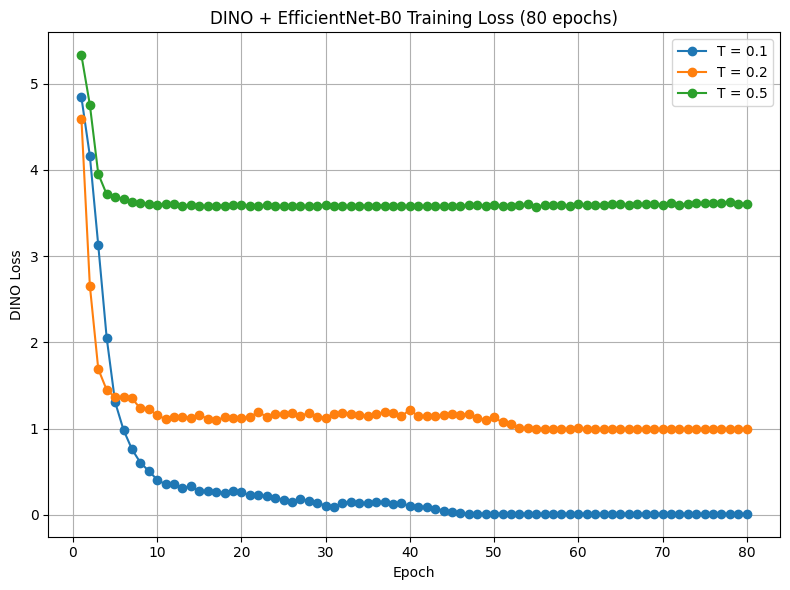

In [17]:
# ======================================
# STEP 7: PLOT DINO TRAINING LOSS (3 TEMPS)
# ======================================
plt.figure(figsize=(8, 6))

for temp in TEMPERATURES:
    losses = dino_loss_histories[temp]
    plt.plot(range(1, len(losses)+1), losses, marker="o", label=f"T = {temp}")

plt.xlabel("Epoch")
plt.ylabel("DINO Loss")
plt.title("DINO + EfficientNet-B0 Training Loss (80 epochs)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
#Evaluation dataset + loader (simple, no heavy aug)

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Eval transform: only resize + center crop + normalize
eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_dataset = datasets.ImageFolder(
    root=cfg.TRAIN_DIR,   # same Fishes/augmented folder
    transform=eval_transform
)

eval_loader = DataLoader(
    eval_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True
)

print("Eval dataset size:", len(eval_dataset))
print("Num classes:", len(eval_dataset.classes))
print("Classes:", eval_dataset.classes)


Eval dataset size: 5830
Num classes: 21
Classes: ['Baim', 'Bata', 'Batasio(tenra)', 'Chitul', 'Croaker(Poya)', 'Hilsha', 'Kajoli', 'Meni', 'Pabda', 'Poli', 'Puti', 'Rita', 'Rui', 'Rupchada', 'Silver Carp', 'Telapiya', 'carp', 'k', 'kaikka', 'koral', 'shrimp']


In [19]:
#Feature extraction from DINO student encoder (multi-temp)
import numpy as np
import torch

def extract_features_from_dino(encoder, dataloader, max_samples=None):
    encoder.to(cfg.DEVICE)
    encoder.eval()

    feats_list, labels_list = [], []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(cfg.DEVICE, non_blocking=True)
            feats = encoder(imgs)          # [B, D]
            feats_list.append(feats.cpu())
            labels_list.append(labels.cpu())

            if max_samples is not None:
                if sum(len(x) for x in labels_list) >= max_samples:
                    break

    feats = torch.cat(feats_list, dim=0)
    labs = torch.cat(labels_list, dim=0)

    if max_samples is not None and len(labs) > max_samples:
        feats = feats[:max_samples]
        labs = labs[:max_samples]

    return feats.numpy(), labs.numpy()


# -------- cache features for all DINO temps --------
features_by_temp = {}
labels_by_temp = {}

for temp in TEMPERATURES:
    print(f"\nExtracting features from DINO student (T={temp})")
    student = dino_students[temp]
    encoder = student.encoder   # EfficientNet-B0 encoder

    X, y = extract_features_from_dino(encoder, eval_loader, max_samples=None)
    print(f"T={temp} → features: {X.shape}, labels: {y.shape}")

    features_by_temp[temp] = X
    labels_by_temp[temp] = y



Extracting features from DINO student (T=0.1)
T=0.1 → features: (5830, 1280), labels: (5830,)

Extracting features from DINO student (T=0.2)
T=0.2 → features: (5830, 1280), labels: (5830,)

Extracting features from DINO student (T=0.5)
T=0.5 → features: (5830, 1280), labels: (5830,)



Linear Probe on DINO Features (T = 0.1)

Accuracy (DINO + EffNet-B0, T=0.1): 62.86%

Classification Report:
                precision    recall  f1-score   support

          Baim       0.56      0.60      0.58        68
          Bata       0.64      0.73      0.68        52
Batasio(tenra)       0.58      0.55      0.56        64
        Chitul       0.87      0.92      0.90        98
 Croaker(Poya)       0.85      0.50      0.63        22
        Hilsha       0.56      0.65      0.60        54
        Kajoli       0.58      0.58      0.58        96
          Meni       0.46      0.56      0.51        62
         Pabda       0.53      0.53      0.53        86
          Poli       0.66      0.74      0.69        34
          Puti       0.70      0.57      0.63        56
          Rita       0.71      0.58      0.64        26
           Rui       0.81      0.66      0.72        38
      Rupchada       0.74      0.62      0.68        32
   Silver Carp       0.62      0.57      0.59     

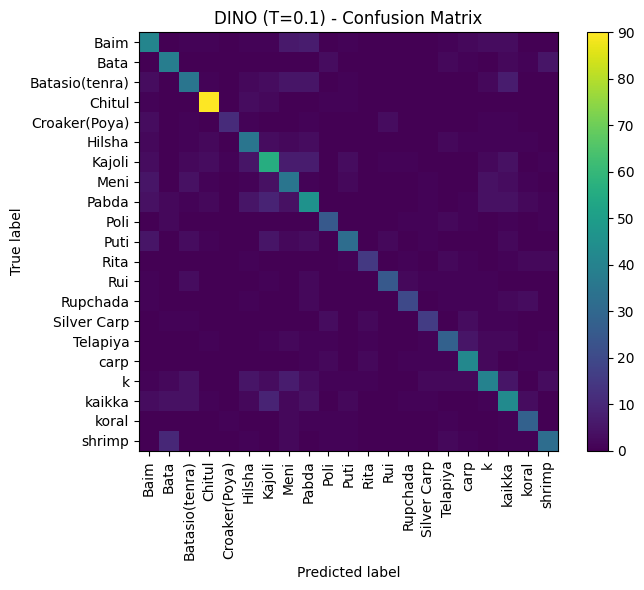


Linear Probe on DINO Features (T = 0.2)

Accuracy (DINO + EffNet-B0, T=0.2): 64.24%

Classification Report:
                precision    recall  f1-score   support

          Baim       0.57      0.65      0.61        68
          Bata       0.62      0.77      0.69        52
Batasio(tenra)       0.56      0.61      0.58        64
        Chitul       0.84      0.90      0.87        98
 Croaker(Poya)       0.71      0.55      0.62        22
        Hilsha       0.62      0.65      0.64        54
        Kajoli       0.58      0.59      0.58        96
          Meni       0.59      0.61      0.60        62
         Pabda       0.63      0.57      0.60        86
          Poli       0.73      0.65      0.69        34
          Puti       0.70      0.66      0.68        56
          Rita       0.77      0.65      0.71        26
           Rui       0.78      0.74      0.76        38
      Rupchada       0.68      0.53      0.60        32
   Silver Carp       0.71      0.54      0.61     

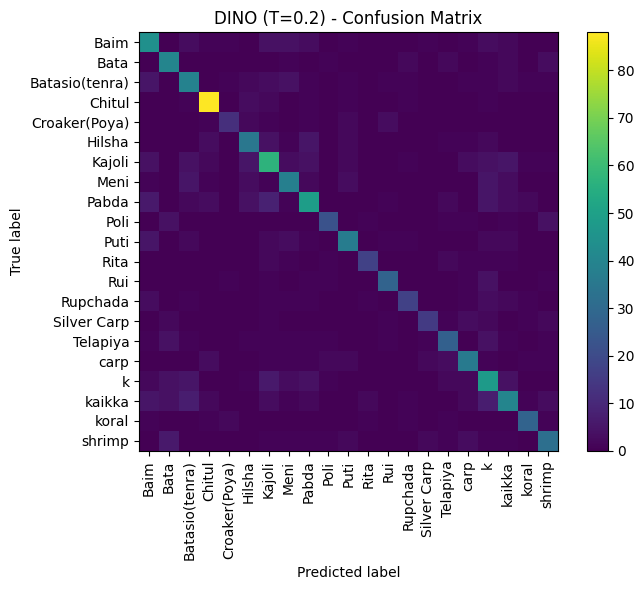


Linear Probe on DINO Features (T = 0.5)

Accuracy (DINO + EffNet-B0, T=0.5): 62.52%

Classification Report:
                precision    recall  f1-score   support

          Baim       0.52      0.62      0.56        68
          Bata       0.63      0.75      0.68        52
Batasio(tenra)       0.55      0.56      0.56        64
        Chitul       0.87      0.88      0.87        98
 Croaker(Poya)       0.76      0.59      0.67        22
        Hilsha       0.55      0.63      0.59        54
        Kajoli       0.55      0.54      0.54        96
          Meni       0.64      0.63      0.63        62
         Pabda       0.56      0.58      0.57        86
          Poli       0.72      0.68      0.70        34
          Puti       0.67      0.52      0.59        56
          Rita       0.62      0.62      0.62        26
           Rui       0.73      0.63      0.68        38
      Rupchada       0.57      0.62      0.60        32
   Silver Carp       0.70      0.57      0.63     

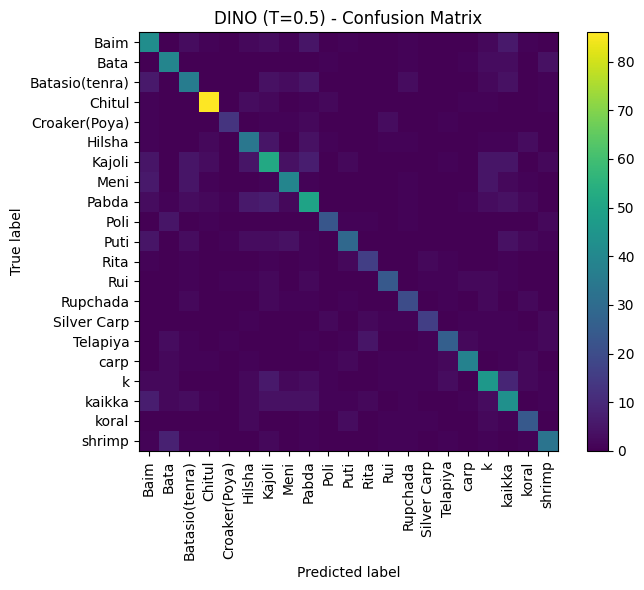


DINO LINEAR PROBE SUMMARY:
   Temperature  Accuracy (%)
0          0.1     62.864494
1          0.2     64.236707
2          0.5     62.521441

Best temperature for DINO (by linear probe): T = 0.2


In [21]:
#Linear probe + Confusion Matrix heatmap (for all temps)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

temperature_results = {}

for temp in TEMPERATURES:
    print("\n" + "="*60)
    print(f"Linear Probe on DINO Features (T = {temp})")
    print("="*60)

    X = features_by_temp[temp]
    y = labels_by_temp[temp]

    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.2,
        random_state=cfg.SEED,
        stratify=y
    )

    clf = LogisticRegression(max_iter=2000, n_jobs=-1)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)

    print(f"\nAccuracy (DINO + EffNet-B0, T={temp}): {acc*100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred, target_names=eval_dataset.classes))

    cm = confusion_matrix(y_val, y_pred)
    print("Confusion Matrix (numeric):")
    print(cm)

    # ----- Confusion matrix heatmap -----
    plt.figure(figsize=(8, 6))
    im = plt.imshow(cm, interpolation="nearest")
    plt.title(f"DINO (T={temp}) - Confusion Matrix")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    num_classes = len(eval_dataset.classes)
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, eval_dataset.classes, rotation=90)
    plt.yticks(tick_marks, eval_dataset.classes)

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

    temperature_results[temp] = {
        "accuracy": acc,
        "cm": cm,
        "y_true": y_val,
        "y_pred": y_pred
    }

# Small summary table
summary = {
    "Temperature": [],
    "Accuracy (%)": []
}
for temp in TEMPERATURES:
    summary["Temperature"].append(temp)
    summary["Accuracy (%)"].append(temperature_results[temp]["accuracy"] * 100)

df_summary = pd.DataFrame(summary)
print("\nDINO LINEAR PROBE SUMMARY:")
print(df_summary)

# Choose best temp for visualization
best_temp = max(temperature_results, key=lambda t: temperature_results[t]["accuracy"])
print(f"\nBest temperature for DINO (by linear probe): T = {best_temp}")



LINEAR PROBE (DINO features) for T = 0.1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(



Accuracy (T=0.1): 62.61%

Classification Report:
                precision    recall  f1-score   support

          Baim       0.57      0.62      0.59        68
          Bata       0.64      0.73      0.68        52
Batasio(tenra)       0.58      0.55      0.56        64
        Chitul       0.87      0.91      0.89        98
 Croaker(Poya)       0.85      0.50      0.63        22
        Hilsha       0.56      0.65      0.60        54
        Kajoli       0.57      0.57      0.57        96
          Meni       0.47      0.53      0.50        62
         Pabda       0.52      0.53      0.53        86
          Poli       0.64      0.74      0.68        34
          Puti       0.70      0.57      0.63        56
          Rita       0.71      0.58      0.64        26
           Rui       0.78      0.66      0.71        38
      Rupchada       0.76      0.59      0.67        32
   Silver Carp       0.64      0.57      0.60        28
      Telapiya       0.62      0.61      0.62        

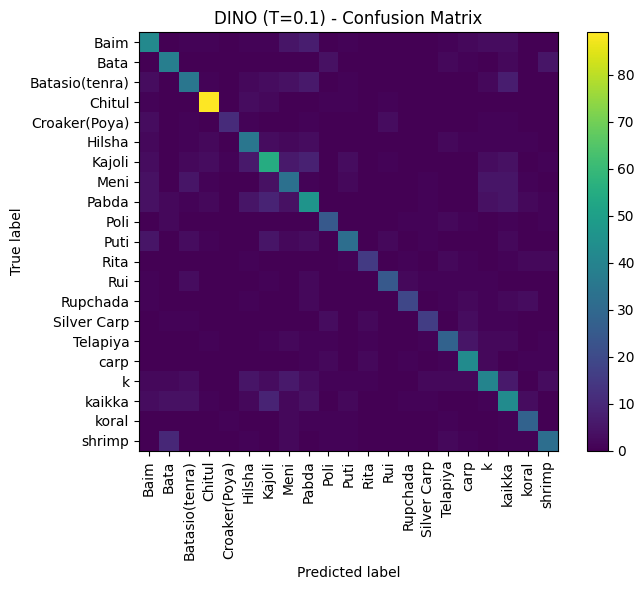

Macro ROC–AUC (T=0.1): 0.9414


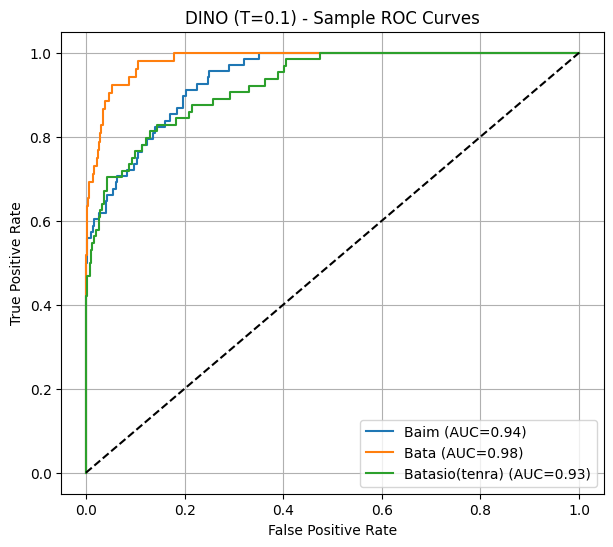


LINEAR PROBE (DINO features) for T = 0.2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(



Accuracy (T=0.2): 63.89%

Classification Report:
                precision    recall  f1-score   support

          Baim       0.58      0.65      0.61        68
          Bata       0.62      0.77      0.69        52
Batasio(tenra)       0.56      0.61      0.58        64
        Chitul       0.82      0.90      0.86        98
 Croaker(Poya)       0.71      0.55      0.62        22
        Hilsha       0.62      0.65      0.64        54
        Kajoli       0.58      0.59      0.59        96
          Meni       0.59      0.60      0.59        62
         Pabda       0.62      0.56      0.59        86
          Poli       0.71      0.65      0.68        34
          Puti       0.69      0.66      0.67        56
          Rita       0.77      0.65      0.71        26
           Rui       0.78      0.74      0.76        38
      Rupchada       0.65      0.53      0.59        32
   Silver Carp       0.68      0.54      0.60        28
      Telapiya       0.63      0.59      0.61        

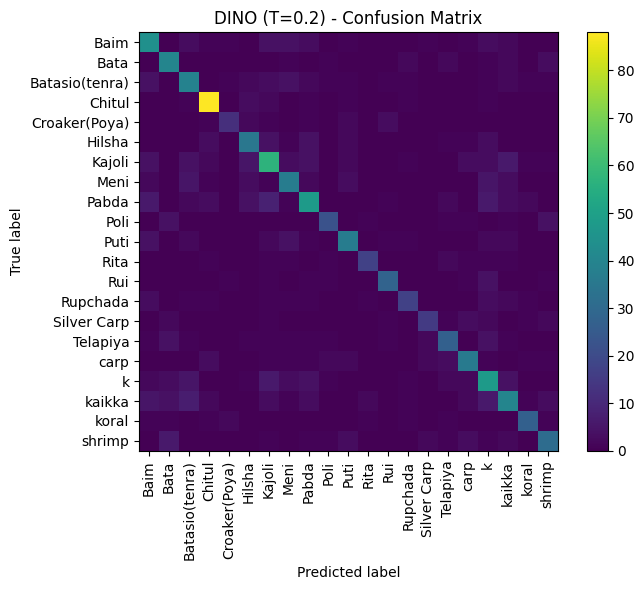

Macro ROC–AUC (T=0.2): 0.9380


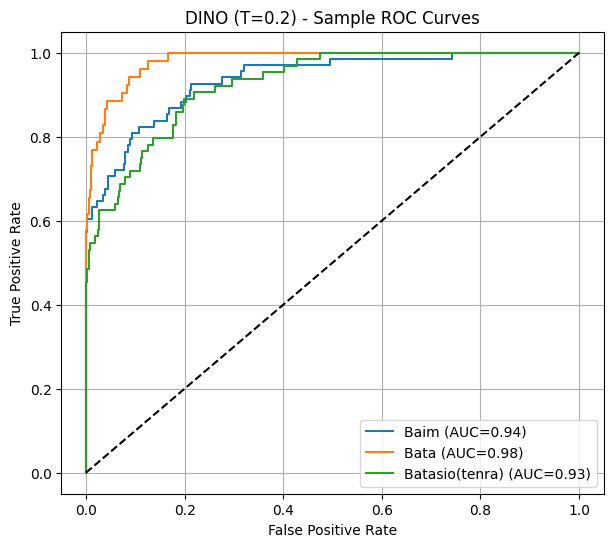


LINEAR PROBE (DINO features) for T = 0.5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(



Accuracy (T=0.5): 62.52%

Classification Report:
                precision    recall  f1-score   support

          Baim       0.54      0.62      0.58        68
          Bata       0.63      0.75      0.68        52
Batasio(tenra)       0.56      0.58      0.57        64
        Chitul       0.87      0.88      0.87        98
 Croaker(Poya)       0.72      0.59      0.65        22
        Hilsha       0.53      0.63      0.58        54
        Kajoli       0.54      0.53      0.53        96
          Meni       0.64      0.63      0.63        62
         Pabda       0.56      0.58      0.57        86
          Poli       0.72      0.68      0.70        34
          Puti       0.67      0.52      0.59        56
          Rita       0.62      0.62      0.62        26
           Rui       0.73      0.63      0.68        38
      Rupchada       0.56      0.62      0.59        32
   Silver Carp       0.70      0.57      0.63        28
      Telapiya       0.70      0.57      0.63        

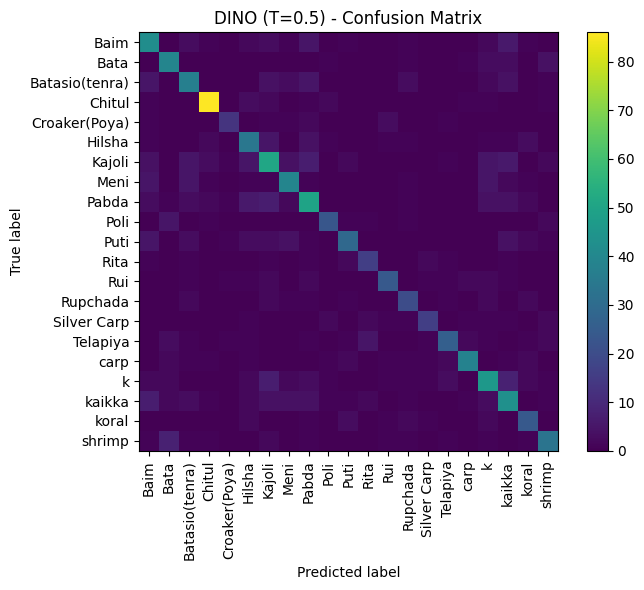

Macro ROC–AUC (T=0.5): 0.9392


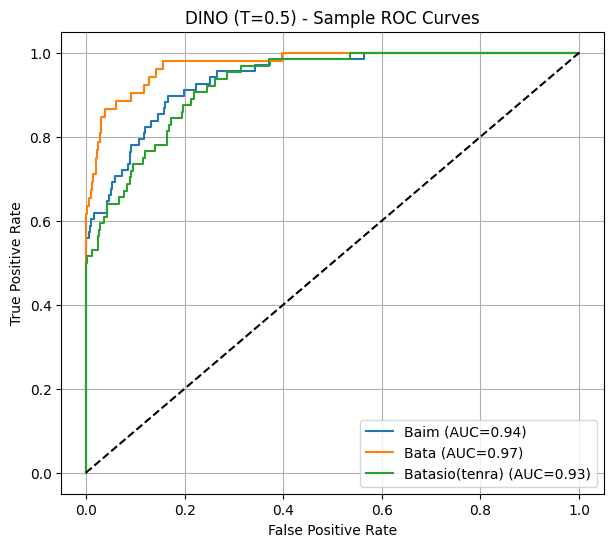


SUMMARY (Linear Probe, Accuracy):
T = 0.1 → Acc = 62.61%, Macro AUC = 0.9414
T = 0.2 → Acc = 63.89%, Macro AUC = 0.9380
T = 0.5 → Acc = 62.52%, Macro AUC = 0.9392


In [25]:
# ======================================
# CELL 1: LINEAR PROBE + METRICS
# ======================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

linear_results = {}

for temp in TEMPERATURES:
    print("\n" + "="*60)
    print(f"LINEAR PROBE (DINO features) for T = {temp}")
    print("="*60)

    X = features_by_temp[temp]
    y = labels_by_temp[temp]

    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.2,
        random_state=cfg.SEED,
        stratify=y
    )

    clf = LogisticRegression(max_iter=2000, n_jobs=-1)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    y_proba = clf.predict_proba(X_val)

    # -------- Accuracy & per-class metrics --------
    acc = accuracy_score(y_val, y_pred)
    print(f"\nAccuracy (T={temp}): {acc*100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred, target_names=eval_dataset.classes))

    # -------- Confusion Matrix + Heatmap --------
    cm = confusion_matrix(y_val, y_pred)
    print("Confusion Matrix (numeric):")
    print(cm)

    plt.figure(figsize=(8, 6))
    im = plt.imshow(cm, interpolation="nearest")
    plt.title(f"DINO (T={temp}) - Confusion Matrix")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    num_classes = len(eval_dataset.classes)
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, eval_dataset.classes, rotation=90)
    plt.yticks(tick_marks, eval_dataset.classes)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

    # -------- ROC–AUC (macro, multiclass) --------
    y_bin = label_binarize(y_val, classes=np.arange(num_classes))
    macro_auc = roc_auc_score(y_bin, y_proba, multi_class="ovr", average="macro")
    print(f"Macro ROC–AUC (T={temp}): {macro_auc:.4f}")

    # Example ROC curve for first min(3) classes
    plt.figure(figsize=(7, 6))
    for i in range(min(3, num_classes)):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
        auc_i = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{eval_dataset.classes[i]} (AUC={auc_i:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"DINO (T={temp}) - Sample ROC Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

    linear_results[temp] = {
        "accuracy": acc,
        "cm": cm,
        "macro_auc": macro_auc
    }

print("\nSUMMARY (Linear Probe, Accuracy):")
for temp in TEMPERATURES:
    print(f"T = {temp} → Acc = {linear_results[temp]['accuracy']*100:.2f}%, "
          f"Macro AUC = {linear_results[temp]['macro_auc']:.4f}")
